## CS 644 - Final Project 

##### Group Members :- Smeet Kathiria 



# Project Part 1 -> Data Analysis

In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("./training.1600000.processed.noemoticon.csv",header=None, names=['sentiment','id','date','query_string','user','text'], encoding='ISO-8859-1')


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)


In [ ]:
df.head()


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.sentiment.value_counts()


4    800000
0    800000
Name: sentiment, dtype: int64

##### There are total 1.6 million rows and no null values, also there is no sentiment with neutral class only positive and negative values are there. There is no skewness since the data is equally divided amon positve and negative class. 

In [ ]:
df[df.sentiment == 4].head(10)


,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


##### looks like all the tweets with positive sentiment starts from 800000 index  
 



In [ ]:
import seaborn as sns


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


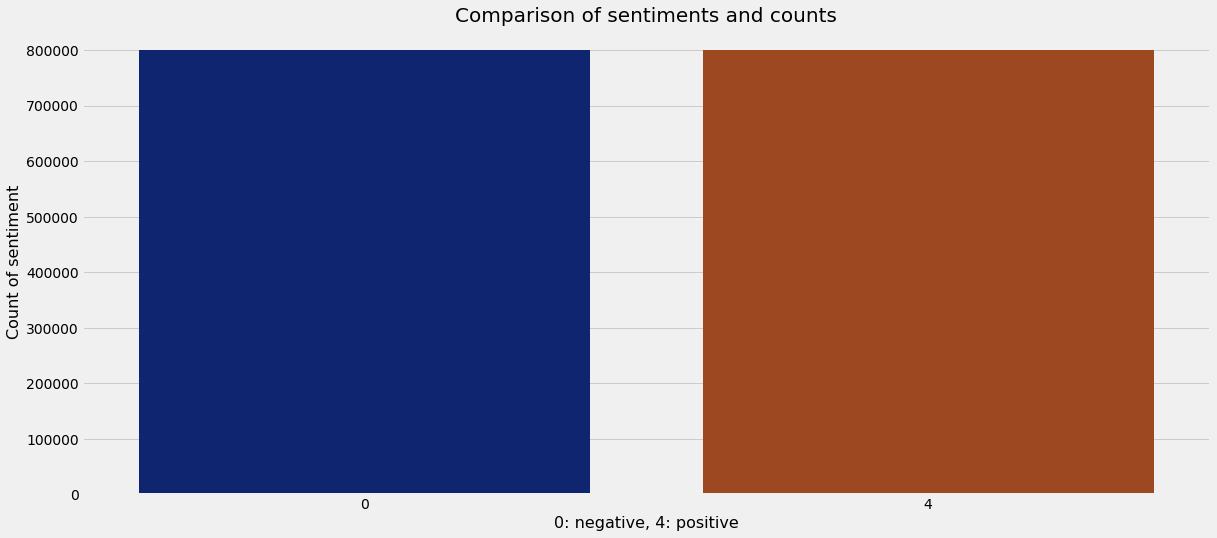

In [ ]:
plt.figure(figsize = (18, 8))
plt.style.use('fivethirtyeight')
ax = sns.countplot('sentiment', data = df, palette = 'dark')
ax.set_xlabel(xlabel = '0: negative, 4: positive', fontsize = 16)
ax.set_ylabel(ylabel = 'Count of sentiment', fontsize = 16)
ax.set_title(label = 'Comparison of sentiments and counts', fontsize = 20)
plt.show()

##### later we will convert the all the sentiment classified as 4 to 1 just to be more consistent 




In [ ]:
from wordcloud import WordCloud  # importing the worldcloud module. Wordcloud uses the text sizes to represent the frequency of the text

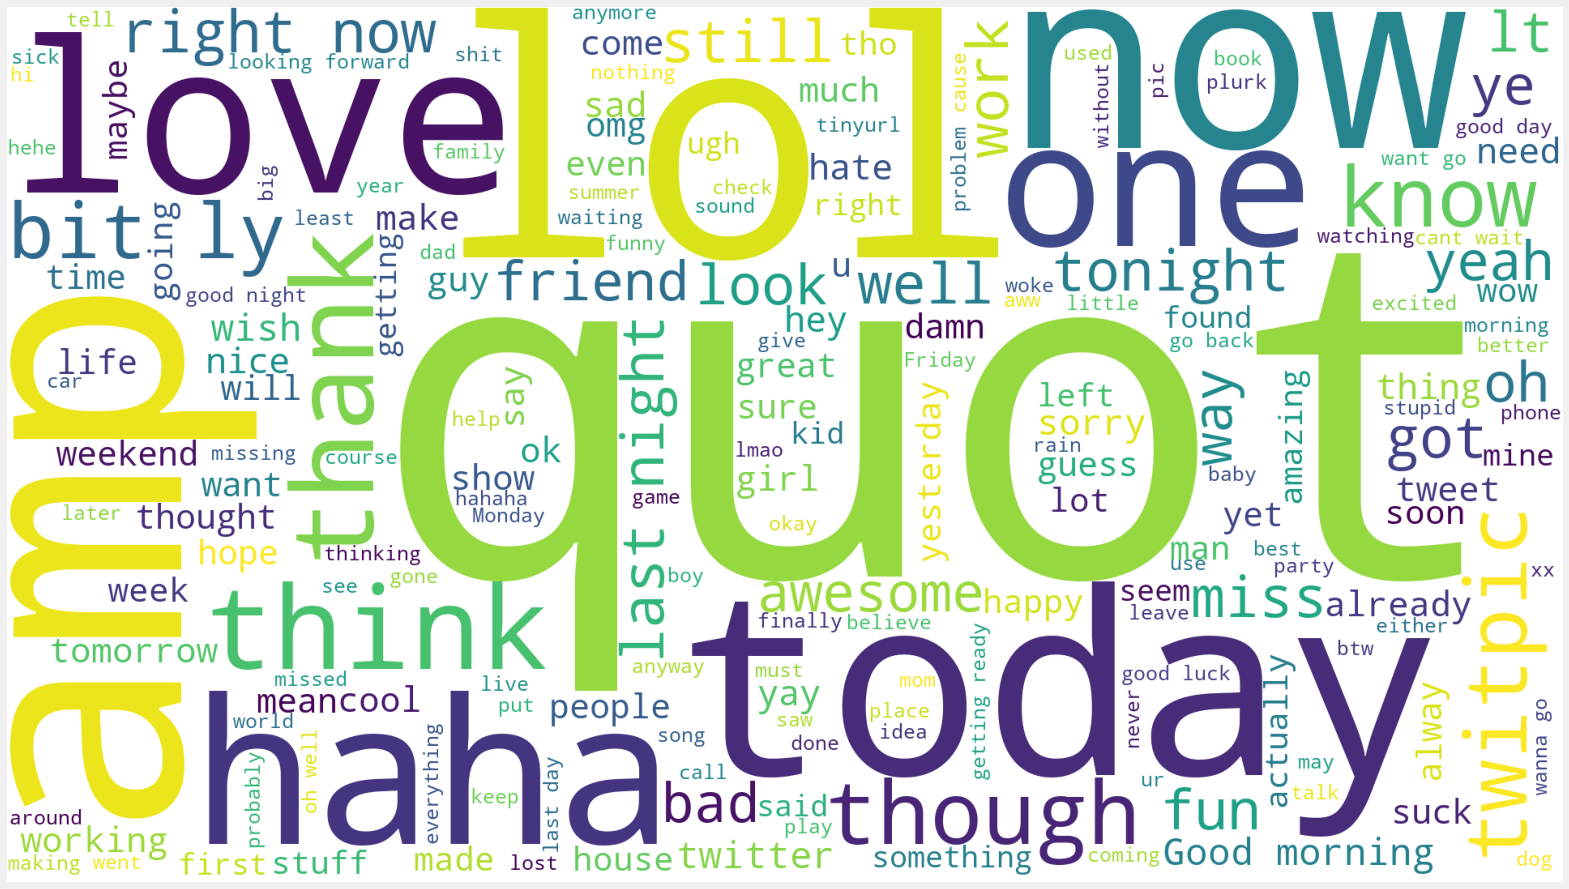

In [ ]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1920,
                          height=1080
                         ).generate(" ".join(df.text))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')
plt.show()

##### Checking the length of string in text column  




In [ ]:
df['text_len'] = [len(t) for t in df.text]


In [ ]:
pd.set_option('display.max_colwidth', None)


In [ ]:
df[df.text_len > 160].head(10)


,sentiment,text,text_len
13538,0,"Took niece &amp; nephew to Blockbuster- rented &quot;Marley&amp;me&quot;, &amp; &quot;Slumdog Millionaire&quot; Niece kiki799 reinjured ankle @ last night b-ball game",167
16809,0,@SongzYuuup wat is the name of ur mixtape with &quot;r u a performer&quot; &amp; &quot;do u kno what la pearla is&quot; i lost all my music and i ? that mixtape,161
19818,0,I don't like it when people use the word &quot;fag&quot; &quot;gay&quot; or &quot;retarded&quot; as a derogative term to describe things they don't like. It's immature,168
26880,0,"@victoriax3jonas such as the &quot;we will do this forever&quot;, &quot;what I see&quot;, &amp; &quot;we love fans&quot; but the binding of the book effed up my plans haha",172
29196,0,"Maybe it's just me, but when someone tells me &quot;Have a nice day,&quot; my response is usually &quot;You too,&quot; not &quot;I will,&quot; &quot;Yeah,&quot; or &quot;Whatever.&quot;",186
50881,0,"&quot;Simple Plan, Simple Plan, Simple Plan...&quot; The show was amazing! When will ut be &quot;McFLY, McFLY...&quot; or &quot;30STM, 30STM ..&quot; look like NEVER",166
68913,0,ok..2 of the songs deleted off my comp was &quot;games&quot;...&amp; &quot;didnt i blow ur mind&quot; any1 wanna email me those mp3s? i cant find my box of cds!,161
77884,0,"http://bit.ly/hJERF I still want to see &quot;Limits of Control,&quot; but it of course isn't playing on Maui. But &quot;Obsessed&quot; and &quot;Fighting&quot; are.",166
99690,0,"....k.... 1.7miles south, now.............. ï¿½ber 3 Berge muss ich gehn bis der &quot;pss-pss-pss' sound kommt.........(will nich) &gt;&gt;&gt;&quot;MUSS&quot;&lt;&lt;&lt;",173
106045,0,went on yahoo the headline was &quot;michael phelps finally beaten&quot; i was like &quot;YES FINALLY!&quot; but turns out i confused &quot;beaten&quot; with &quot;beatin&quot;,177


In [ ]:
df[df.text_len > 200].head(5)


,sentiment,text,text_len
248973,0,"Ð?ÑÑ, OpenOffice Ð²ÑÐ±ÐµÑ?Ð¸Ð» Ñ?Ð²Ð¾ÐµÐ¹ Ð½ÐµÑ?ÑÐ°Ð±Ð¸Ð»ÑÐ½Ð¾Ñ?ÑÑÑ Ð¿ÑÐ¸ ÑÐ°Ð±Ð¾ÑÐµ Ñ? ÑÐ°Ð±Ð»Ð¸ÑÐ°Ð¼Ð¸, Ð²ÑÐµÐ¼ÐµÐ½Ð½Ð¾ Ð¿ÐµÑÐµÐµÐ·Ð¶Ð°Ñ Ð¾Ð±ÑÐ°ÑÐ½Ð¾ Ð½Ð° M$. Ð§ÑÐ²Ñ?ÑÐ²ÑÑ Ñ?ÐµÐ±Ñ? Ð¿ÑÐµÐ´Ð°ÑÐµÐ»ÐµÐ¼",226
305242,0,"èªª åé«éå¾ç¬¬ä¸å (LOL),æ²æ³å°è?¸å®³é²æ²»æ³å¯¦è¡å¾,ä¸?ç¥é?æéº¼æ¨£,æä¹å?å¸¸å»çåäº (annoyed),å°å?¦ä¸ééè²¼èå ¨é?¢ç¦?è?¸,å?¯æ¯ä¸é²å»å?æ¯ä¸å ç å³ http://plurk.com/p/xryp0",213
322655,0,"Ð¾Ð±Ð¸Ð´Ð½Ð¾ ÑÑÐ¾ Ð¼Ð½Ð¾Ð³Ð¸Ðµ ÑÐ²Ð¸ÑÐµÑÑ?Ð½Ðµ Ð½Ðµ Ð·Ð°Ð¼ÐµÑÐ°ÑÑ ÐºÐ¾Ð³Ð´Ð° Ð¸Ð¼ Ð¾ÑÐ¿ÑÐ°Ð²Ð»Ñ?ÐµÑÑ reply, Ð° direct Ð¼Ð¾Ð¶Ð½Ð¾ Ð¾ÑÐ¿ÑÐ°Ð²Ð»Ñ?ÑÑ ÑÐ¾Ð»ÑÐºÐ¾ ÑÐµÐ¼ ÐºÑÐ¾ ÑÐµÐ±Ñ? ÑÐ¸ÑÐ°ÐµÑ",211
324570,0,"ÐÐºÐ°Ð·Ð°Ð»Ð¾Ñ?Ñ, ÑÑÐ¾ Ð¿ÑÐµÑ?Ñ?-ÐºÐ¾Ð½ÑÐµÑÐµÐ½ÑÐ¸Ñ? SONY Ð² Home Ð¿Ð¾Ñ?Ð²Ð¸ÑÑ?Ñ? ÑÐµÑÐµÐ· Ð½ÐµÑ?ÐºÐ¾Ð»ÑÐºÐ¾ ÑÐ°Ñ?Ð¾Ð² Ð¿Ð¾Ñ?Ð»Ðµ Ð¿ÑÐµÑ?Ñ?-ÐºÐ¾Ð½ÑÐµÑÐµÐ½ÑÐ¸Ð¸ Ð¡Ð¼Ð¾ÑÑÑ ÑÐµÑÐµÐ· PS3 Ñ? Ð³ÐµÐ¹Ð¼Ñ?Ð¿Ð¾ÑÐ°",227
325649,0,"@Arwy Ð´Ð¸Ñ?Ðº Ð½Ðµ Ð¿ÑÐ¾Ð²ÐµÑÑ?Ð», Ð½Ðµ Ð·Ð½Ð°Ñ. Ð?Ð¾ Ð¿Ð¾ÐºÐ°Ð·Ð°Ð»Ð¾Ñ?Ñ, ÑÑÐ¾ backup Ð°Ð¹ÑÐ¾Ð½Ð° Ð¾Ð¿Ñ?ÑÑ Ð´ÐµÐ»Ð°ÐµÑÑ?Ñ? Ð´Ð¾Ð»Ð³Ð¾ Ð² Ð¿ÑÐ¾ÑÐ»Ð¾Ð¹ Ð²ÐµÑÑ?Ð¸Ð¸ Ð²ÑÐ¾Ð´Ðµ Ð¿Ð¾Ð¿ÑÐ°Ð²Ð¸Ð»Ð¸, Ð° Ñ?ÐµÐ¹ÑÐ°Ñ? Ð¾Ð¿Ñ?ÑÑ!",236


In [ ]:
df[df.text_len >50].tail(10)


,sentiment,text,text_len
1599985,4,"if ur the lead singer in a band, beware falling prey to LSD &quot;Lead Singer Disease&quot; http://tinyurl.com/n65xjt #music #haveyouever?",139
1599987,4,@La_r_a NEVEER I think that you both will get on well with each other...,73
1599988,4,@Roy_Everitt ha- good job. that's right - we gotta throw that #bigrun tag EVERYWHERE! I wanna get it trending before I start,125
1599991,4,@rmedina @LaTati Mmmm That sounds absolutely perfect... but my schedule is full. I won't have time to lay in bed until Sunday. Ugh!!,133
1599994,4,"@Cliff_Forster Yeah, that does work better than just waiting for it In the end I just wonder if I have time to keep up a good blog.",132
1599995,4,Just woke up. Having no school is the best feeling ever,56
1599996,4,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta,78
1599997,4,Are you ready for your MoJo Makeover? Ask me for details,57
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur,65
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H,62


##### from the above dataframes we can see inside the text column that there are urls, @username mentions , HTML decoding error where we can see that the decoding is not text converted  like &quot etc, also there are many gibberish values that does not make sense. Also there are some words like won't haven't which we will change to would not and have not for the model to train better along with handling all the above things mentioned. 




  

##### Now we write a function to transform the tweets and solve above mentioned problems 



In [ ]:
from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup


In [ ]:
tok = WordPunctTokenizer()
#handling urls and user mentions
combined_pat = r'|'.join((r'@[A-Za-z0-9_]+', r'https?://[^ ]+'))

negations_catalog = {"isn't":"is not", 
                     "aren't":"are not", 
                     "wasn't":"was not", 
                     "weren't":"were not",
                     "haven't":"have not",
                     "hasn't":"has not",
                     "hadn't":"had not",
                     "won't":"will not",
                     "wouldn't":"would not", 
                     "don't":"do not", 
                     "doesn't":"does not",
                     "didn't":"did not",
                     "can't":"can not",
                     "couldn't":"could not",
                     "shouldn't":"should not",
                     "mightn't":"might not",
                     "mustn't":"must not"}

neg_regex = re.compile(r'\b(' + '|'.join(negations_catalog.keys()) + r')\b')

def tweets_transformer(text):
  # handling decoding of HTML 
    soup = BeautifulSoup(text, 'lxml')
    get_soup_text = soup.get_text()
    
    try:
        bom_eliminator = get_soup_text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_eliminator = get_soup_text
        
    strip_text = re.sub(combined_pat, '', bom_eliminator)
    strip_text = re.sub(r'www.[^ ]+', '', strip_text)
    lower_case = strip_text.lower()
    # converting words from isn't to is not and likewise for all similar words inside the text. 
    neg_transform = neg_regex.sub(lambda x: negations_catalog[x.group()], lower_case)
    # handling hashtags and numbers 
    letters_filter = re.sub("[^a-zA-Z]", " ", neg_transform)
    words = [x for x  in tok.tokenize(letters_filter) if len(x) > 1]
    cleaned_text = (" ".join(words)).strip()
    return cleaned_text

In [ ]:
check_tweets = []
for t in df.text[:100]:
    check_tweets.append(tweets_transformer(t))

In [ ]:
pd.DataFrame(check_tweets).head(20)

,0
0,awww that bummer you shoulda got david carr of third day to do it
1,is upset that he can not update his facebook by texting it and might cry as result school today also blah
2,dived many times for the ball managed to save the rest go out of bounds
3,my whole body feels itchy and like its on fire
4,no it not behaving at all mad why am here because can not see you all over there
5,not the whole crew
6,need hug
7,hey long time no see yes rains bit only bit lol fine thanks how you
8,nope they did not have it
9,que me muera


##### Now the text looks much better on which we can create our machine learning model in pyspark. 


